# Importing Libraries

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5f6b5ff2277249b18ef432cf0d44bf45f0945faf286998c8cbb116281c2932f9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import pandas as pd
import wget
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Acquisition

In [ ]:
# url of the raw csv dataset
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
]
[wget.download(url) for url in urls]

['time_series_covid19_confirmed_global.csv',
 'time_series_covid19_deaths_global.csv',
 'time_series_covid19_recovered_global.csv']

# Data preprocessing 

In [ ]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [ ]:

def preprocess_data(df,s):
    ignore = ['Lat', 'Long']
    data = df[[col for col in df if col not in ignore]].groupby(["Country/Region"], as_index=False).sum()
    
    data = data.melt(id_vars=['Country/Region'])
    data['date'] = pd.to_datetime(data['variable'])
    del data['variable']
    data.rename(columns={'value': s}, inplace=True)
    
    data['Country/Region'] = data['Country/Region'].map({'US': 'United States', 
                                                         'Korea, South': 'South Korea'}).fillna(data['Country/Region'])
    
    return data


In [ ]:
conf_cases = preprocess_data(confirmed_df,'Confirmed')
recovered = preprocess_data(recovered_df,'Recovered')
deaths = preprocess_data(deaths_df,'Deaths')

conf_grouped=conf_cases.groupby(["date"]).agg({"Confirmed":'sum'})
recov_grouped=recovered.groupby(["date"]).agg({"Recovered":'sum'})
death_grouped=deaths.groupby(["date"]).agg({"Deaths":'sum'})

print(conf_grouped.shape)
print(recov_grouped.shape)
print(death_grouped.shape)

(148, 1)
(148, 1)
(148, 1)


### Extracting Basic information from the data

In [ ]:
conf_cases.head()

,Country/Region,Confirmed,date
0,Afghanistan,0,2020-01-22
1,Albania,0,2020-01-22
2,Algeria,0,2020-01-22
3,Andorra,0,2020-01-22
4,Angola,0,2020-01-22


In [ ]:
conf_cases.describe()

In [ ]:
recovered.head()

In [ ]:
recovered.describe()

In [ ]:
deaths.head()

In [ ]:
deaths.describe()

In [ ]:
print("number of affected countries : ",len(conf_cases["Country/Region"].unique()))
print("\n")
print("Confirmed Cases worldwide: ",conf_grouped["Confirmed"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(conf_grouped["Confirmed"].iloc[-1]/conf_grouped.shape[0]))
print("\n")
print("Recovered Cases worldwide: ",recov_grouped["Recovered"].iloc[-1])
print("number of Deaths worldwide: ",death_grouped["Deaths"].iloc[-1])
print("Active Cases worldwide: ",(conf_grouped["Confirmed"].iloc[-1]-recov_grouped["Recovered"].iloc[-1]-death_grouped["Deaths"].iloc[-1]))
print("Closed Cases worldwide: ",recov_grouped["Recovered"].iloc[-1]+death_grouped["Deaths"].iloc[-1])
print("\n")
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(conf_grouped["Confirmed"].iloc[-1]/conf_grouped.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(recov_grouped["Recovered"].iloc[-1]/recov_grouped.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(death_grouped["Deaths"].iloc[-1]/death_grouped.shape[0]))


In [ ]:
# Merging confirmed_df and deaths_df
full_data = conf_cases.merge(
  right=deaths, 
  how='left',
  on=[ 'date', 'Country/Region']
)
# Merging full_table and recovered_df
full_data = full_data.merge(
  right=recovered, 
  how='left',
  on=['date', 'Country/Region']
)
"""full_data.head()
cols = full_data.columns.tolist()
cols = cols[2] + cols[:2] + cols[3:]"""
grouped=full_data.groupby(["date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})


# Exploring the data Visually

### 1- Daily distribution of different number of cases

In [ ]:
#Plot of the Distribution of number of Confirmed cases Worldwide

import plotly.express as pex
figure=pex.bar(x=grouped.index,y=grouped["Confirmed"])
figure.update_layout(title="Distribution of Number of Confirmed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
figure.show()

In [ ]:
#Plot of the Distribution of number of Active cases Worldwide

figure=pex.bar(x=grouped.index,y=grouped["Confirmed"]-grouped["Recovered"]-grouped["Deaths"])
figure.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
figure.show()

In [ ]:
#Plot of the Distribution of number of Deaths Worldwide

figure=pex.bar(x=grouped.index,y=grouped["Deaths"])
figure.update_layout(title="Distribution of Number of Deaths",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
figure.show()

In [ ]:
#Plot of the Distribution of number of recovered cases Worldwide
fig=pex.bar(x=grouped.index,y=grouped["Recovered"])
fig.update_layout(title="Distribution of Number of Recovered Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

### 2- Weekly distribution of different types of cases

In [ ]:
#Group the worldwide numbers of different types of cases in terms of weeks:

grouped["WeekOfYear"] = grouped.index.weekofyear

wk_num = []
wkly_confirmed = []
wkly_recoveries = []
wkly_deaths = []
counter = 1
for i in list(grouped["WeekOfYear"].unique()):
    wkly_deaths.append(grouped[grouped["WeekOfYear"]==i]["Deaths"].iloc[-1])
    wkly_confirmed.append(grouped[grouped["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    wkly_recoveries.append(grouped[grouped["WeekOfYear"]==i]["Recovered"].iloc[-1])
    wk_num.append(counter)
    counter=counter+1

Text(0, 0.5, 'Nb of Death Cases')

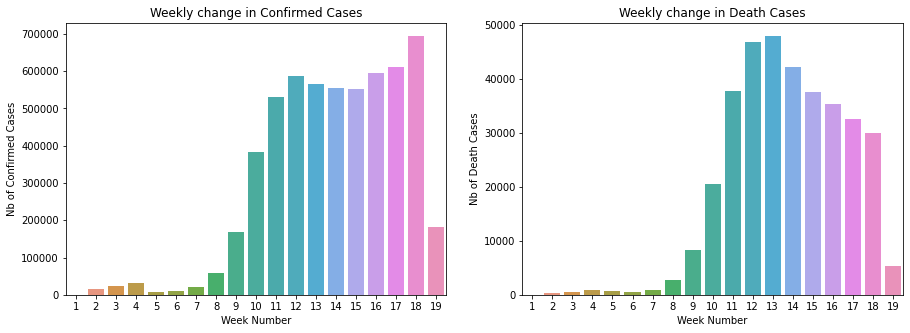

In [ ]:
#Plot the evolution of worldwide confirmed cases and deaths in terms of weeks:

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
#confirmed cases
sns.barplot(x=wk_num,y=pd.Series(wkly_confirmed).diff().fillna(0),ax=ax1)
ax1.set_title("Weekly change in Confirmed Cases")
ax1.set_xlabel("Week Number")
ax1.set_ylabel("Nb of Confirmed Cases")

#Deaths
sns.barplot(x=wk_num,y=pd.Series(wkly_deaths).diff().fillna(0),ax=ax2)
ax2.set_title("Weekly change in Death Cases")
ax2.set_xlabel("Week Number")
ax2.set_ylabel("Nb of Death Cases")


### 3- World map representing Confirmed cases worldwide

In [ ]:
#Plot the world map of countries with comfirmed cases:

aux = full_data[full_data['date'] == max(full_data['date'])].reset_index()
time_grouped = aux.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

figure = pex.choropleth(time_grouped, locations="Country/Region", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Country/Region", range_color=[1,7000], 
                    color_continuous_scale=pex.colors.sequential.Peach, 
                    title='world map of Confirmed Cases')
figure.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
#Restriction of the map to European continent:

europe = list(['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
               'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
               'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
               'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

europe_grouped= time_grouped[time_grouped['Country/Region'].isin(europe)]

figure = pex.choropleth(europe_grouped, locations="Country/Region", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Country/Region", range_color=[1,7000], 
                    color_continuous_scale=pex.colors.sequential.Peach, 
                    title='European Countries with Confirmed Cases', scope='europe', height=800)
figure.show()

### 4- More about Covid19 : Recovery, Mortality rate and growth factor:

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as pgo

#Calculating the Mortality Rate 
grouped["Mortality Rate"]=(grouped["Deaths"]/grouped["Confirmed"])*100
#Calculating the Recovery Rate 
grouped["Recovery Rate"]=(grouped["Recovered"]/grouped["Confirmed"])*100
#Calculating active cases
grouped["Active Cases"]=grouped["Confirmed"]-grouped["Recovered"]-grouped["Deaths"]
#Calculating closed cases 
grouped["Closed Cases"]=grouped["Recovered"]+grouped["Deaths"]

#Plotting Mortality and Recovery Rate 
figure = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
figure.add_trace(
    pgo.Scatter(x=grouped.index, y=grouped["Recovery Rate"],name="Recovery Rate"),
    row=1, col=1
)
figure.add_trace(
    pgo.Scatter(x=grouped.index, y=grouped["Mortality Rate"],name="Mortality Rate"),
    row=2, col=1
)
figure.update_layout(height=800,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
figure.update_xaxes(title_text="Date", col=1, row=1)
figure.update_yaxes(title_text="Recovery Rate", col=1, row=1)
figure.update_xaxes(title_text="Date", col=2, row=1)
figure.update_yaxes(title_text="Mortality Rate", col=2, row=1)
figure.show()


print("Average Mortality Rate",grouped["Mortality Rate"].mean())
print("Average Recovery Rate",grouped["Recovery Rate"].mean())


Average Mortality Rate 4.779278635775958
Average Recovery Rate 27.480793070635617


In [ ]:

figure=pgo.Figure()
figure.add_trace(pgo.Scatter(x=grouped.index, y=grouped["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
figure.add_trace(pgo.Scatter(x=grouped.index, y=grouped["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
figure.add_trace(pgo.Scatter(x=grouped.index, y=grouped["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
figure.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
figure.show()

print("Average Daily change in number of Confirmed Cases: ",np.round(grouped["Confirmed"].diff().fillna(0).mean()))
print("Average Daily change in number of Recovered Cases: ",np.round(grouped["Recovered"].diff().fillna(0).mean()))
print("Average Daily change in number of Deaths Cases: ",np.round(grouped["Deaths"].diff().fillna(0).mean()))


Average Daily change in number of Confirmed Cases:  44358.0
Average Daily change in number of Recovered Cases:  18150.0
Average Daily change in number of Deaths Cases:  2781.0


In [ ]:
figure=pgo.Figure()
figure.add_trace(pgo.Scatter(x=grouped.index, y=grouped["Confirmed"]/grouped["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
figure.add_trace(pgo.Scatter(x=grouped.index, y=grouped["Recovered"]/grouped["Recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
figure.add_trace(pgo.Scatter(x=grouped.index, y=grouped["Deaths"]/grouped["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
figure.update_layout(title="Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
figure.show()

In [ ]:
#Calculating Moratality and Recovery Rate in different countries
by_country=full_data[full_data["date"]==full_data["date"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
by_country["Mortality"]=(by_country["Deaths"]/by_country["Confirmed"])*100
by_country["Recovery"]=(by_country["Recovered"]/by_country["Confirmed"])*100

Text(0.5, 1.0, 'Top 10 countries in terms of recovered Cases')

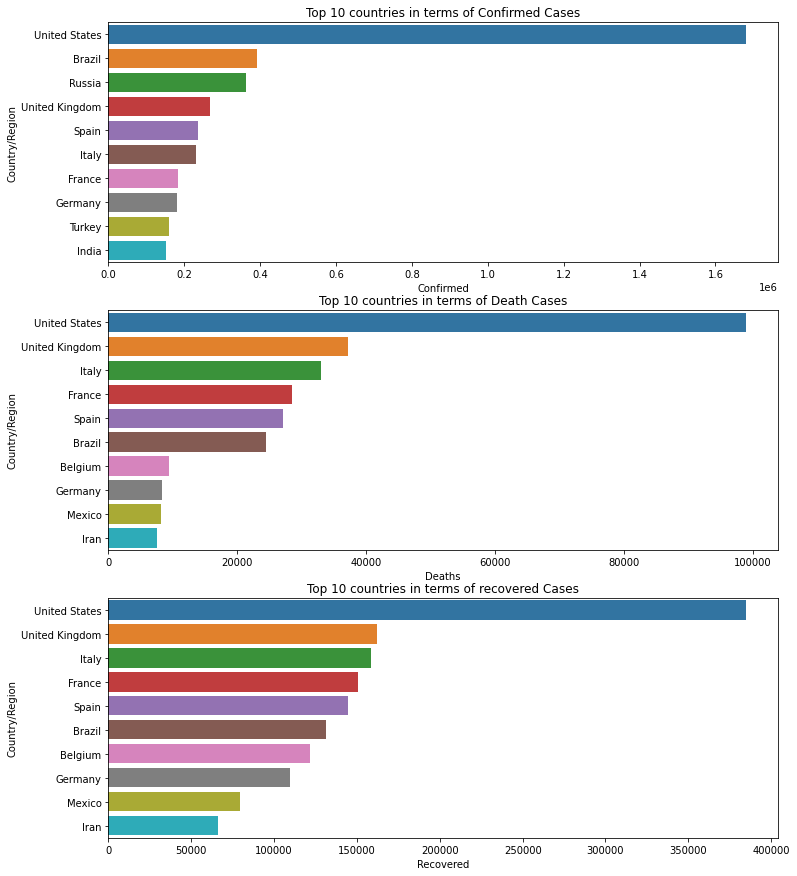

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(12,15))
#Sort countries with respect to different types of cases
top_10_confirmed=by_country.sort_values(["Confirmed"],ascending=False).head(10)
top_10_deaths=by_country.sort_values(["Deaths"],ascending=False).head(10)
top_10_recovered=by_country.sort_values(["Recovered"],ascending=False).head(10)

#Plot Barplot comparing top 10 countries
sns.barplot(x=top_10_confirmed["Confirmed"],y=top_10_confirmed.index,ax=ax1)
ax1.set_title("Top 10 countries in terms of Confirmed Cases")
sns.barplot(x=top_10_deaths["Deaths"],y=top_10_deaths.index,ax=ax2)
ax2.set_title("Top 10 countries in terms of Death Cases")
sns.barplot(x=top_10_recovered["Recovered"],y=top_10_deaths.index,ax=ax3)
ax3.set_title("Top 10 countries in terms of recovered Cases")

In [ ]:
#Journey of different Countries in COVID-19
country_grp=full_data.groupby(["Country/Region","date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
#Let's focus a bit on Europe:
fig = pex.bar(europe_grouped.sort_values('Recovered', ascending=False)[:10][::-1], 
             x='Recovered', y='Country/Region',
             title='Recovered Cases in EUROPE', text='Recovered', orientation='h', color_discrete_sequence=['goldenrod'])
fig.show()

In [ ]:
country_grp["Active Cases"]=country_grp["Confirmed"]-country_grp["Recovered"]-country_grp["Deaths"]
country_grp["log_confirmed"]=np.log(country_grp["Confirmed"])
country_grp["log_active"]=np.log(country_grp["Active Cases"])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



Text(0.5, 1.0, 'COVID-19 Journey of Top 10 countries with Confirmed Cases')

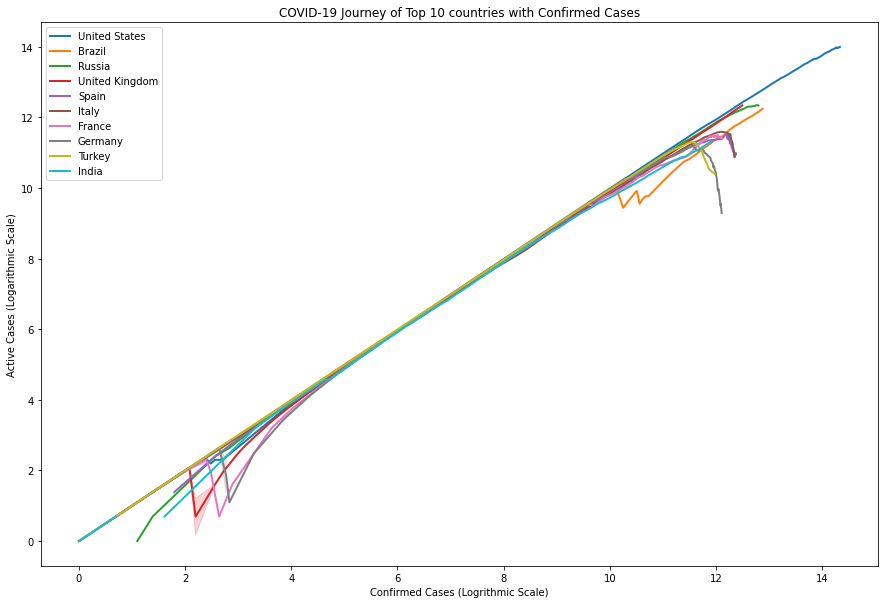

In [ ]:
plt.figure(figsize=(15,10))
for country in by_country.head(10).index:
    sns.lineplot(x=country_grp.loc[country]["log_confirmed"],y=country_grp.loc[country]["log_active"],
                 label=country,linewidth=2)
plt.xlabel("Confirmed Cases (Logrithmic Scale)")
plt.ylabel("Active Cases (Logarithmic Scale)")
plt.title("COVID-19 Journey of Top 10 countries with Confirmed Cases")

### 5- Clustering countries based on the impact of Covid-19

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
std = StandardScaler()
X=country_grp[["Confirmed","Deaths","Recovered"]]
X=std.fit_transform(X)

In [ ]:
#Calculate Silhouette score to validate the consistency within clusters of data.
sds=[]
sil=[]
for i in range(2,12):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    sds.append(clf.inertia_)

Text(0.5, 1.0, 'Silhouette Score Method')

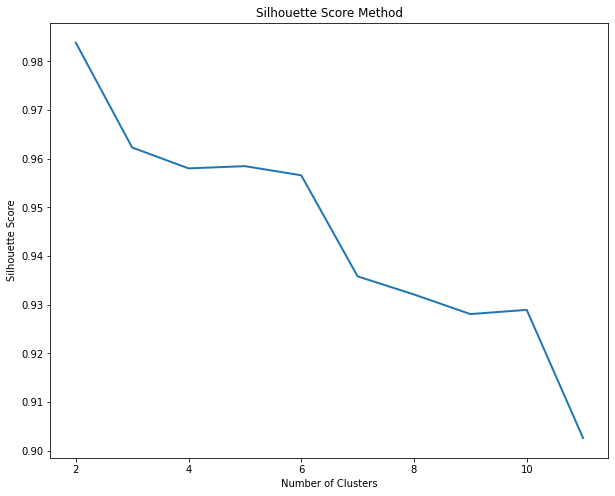

In [ ]:
#Plot the Silhouette score with respect to number of clusters
plt.figure(figsize=(10,8))
sns.lineplot(x=np.arange(2,12),y=sil,linewidth=2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

In [ ]:
#Fix the number of Clusters to 3 and use Kmeans to cluster the data
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=42)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
country_grp["Clusters"]=clf_final.predict(X)

In [ ]:
#A summary of the clustered data
cluster_summary=pd.concat([country_grp[country_grp["Clusters"]==1],country_grp[country_grp["Clusters"]==2],country_grp[country_grp["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds')

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1093: RuntimeWarning:

invalid value encountered in double_scalars



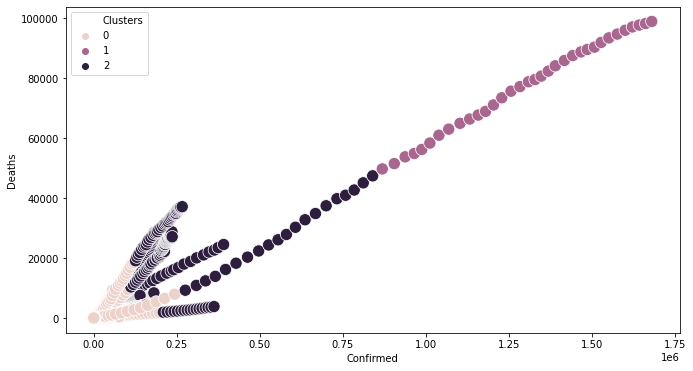

In [ ]:
plt.figure(figsize=(11,6))
sns.scatterplot(x=country_grp["Confirmed"],y=country_grp["Deaths"],hue=country_grp["Clusters"],s = 150)

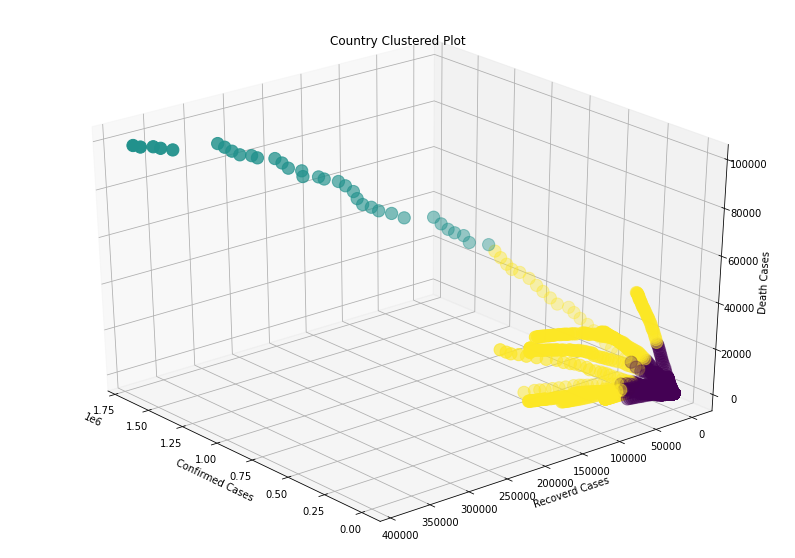

In [ ]:


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(country_grp["Confirmed"],country_grp["Recovered"],country_grp["Deaths"], c=country_grp["Clusters"],
           marker='o',s=150)
ax.view_init(azim=140)
ax.set_xlabel('Confirmed Cases')
ax.set_ylabel('Recoverd Cases')
ax.set_zlabel('Death Cases')
plt.title("Country Clustered Plot")
plt.show()



### 6- Data analysis of Covid19 in Germany:

In [ ]:
#Basic info about Covid-19 in Germany
Germany_covid=full_data[full_data["Country/Region"]=="Germany"]
Germany_grouped=Germany_covid.groupby(["date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(Germany_grouped.iloc[-1])
print("Total Active Cases: ",Germany_grouped["Confirmed"].iloc[-1]-Germany_grouped["Recovered"].iloc[-1]-Germany_grouped["Deaths"].iloc[-1])
print("Total Closed Cases: ",Germany_grouped["Recovered"].iloc[-1]+Germany_grouped["Deaths"].iloc[-1])

Confirmed    181200
Recovered    161967
Deaths         8372
Name: 2020-05-26 00:00:00, dtype: int64
Total Active Cases:  10861
Total Closed Cases:  170339


In [ ]:
#Plot of evolution of different types of cases in Germany over time

figure=pgo.Figure()
figure.update_layout(title="Growth of different types of cases in Germany",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))

figure.add_trace(pgo.Scatter(x=Germany_grouped.index, y=Germany_grouped["Confirmed"],
                    name='Confirmed Cases',
                    mode='lines+markers'))
figure.add_trace(pgo.Scatter(x=Germany_grouped.index, y=Germany_grouped["Recovered"],
                    name='Recovered Cases',
                    mode='lines+markers',))
figure.add_trace(pgo.Scatter(x=Germany_grouped.index, y=Germany_grouped["Deaths"],
                    name='Death Cases',
                    mode='lines+markers'))
figure.show()

In [ ]:
#Plot of evolution of number of active cases in Germany over time

figure=pex.bar(x=Germany_grouped.index,y=Germany_grouped["Confirmed"]-Germany_grouped["Recovered"]-Germany_grouped["Deaths"])
figure.update_layout(xaxis_title="Date",
                     yaxis_title="Number of Cases",
                     title="Distribution of Number of Active Cases in Germany")
figure.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in long_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in long_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in long_scalars



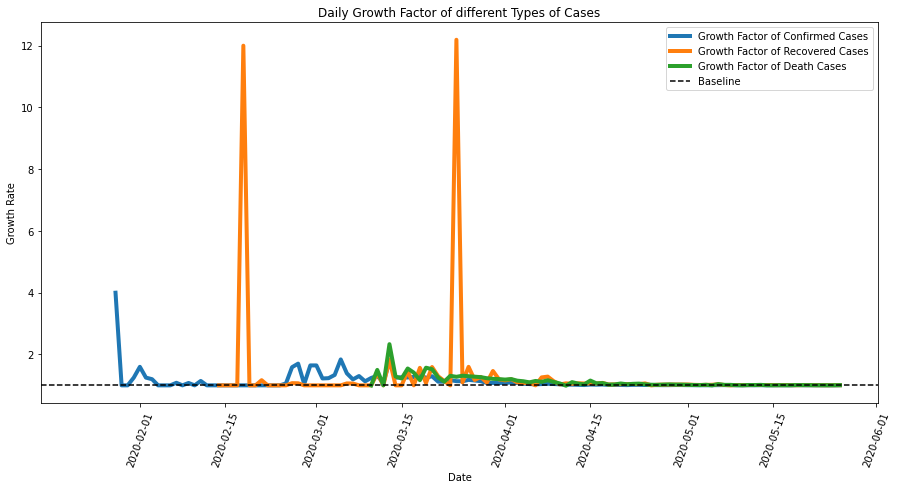

In [ ]:
#Daily Growth Factor of different Types of Cases in Germany

Germany_confirmed=[]
Germany_recovered=[]
Germany_deaths=[]
for i in range(Germany_grouped.shape[0]-1):
    Germany_confirmed.append(((Germany_grouped["Confirmed"].iloc[i+1])/Germany_grouped["Confirmed"].iloc[i]))
    Germany_recovered.append(((Germany_grouped["Recovered"].iloc[i+1])/Germany_grouped["Recovered"].iloc[i]))
    Germany_deaths.append(((Germany_grouped["Deaths"].iloc[i+1])/Germany_grouped["Deaths"].iloc[i]))
Germany_confirmed.insert(0,1)
Germany_recovered.insert(0,1)
Germany_deaths.insert(0,1)

plt.figure(figsize=(15,7))
plt.plot(Germany_grouped.index,Germany_confirmed,label="Growth Factor of Confirmed Cases",linewidth=4)
plt.plot(Germany_grouped.index,Germany_recovered,label="Growth Factor of Recovered Cases",linewidth=4)
plt.plot(Germany_grouped.index,Germany_deaths,label="Growth Factor of Death Cases",linewidth=4)
plt.axhline(1,linestyle='--',color="black",label="Baseline")
plt.xticks(rotation=70)
plt.title("Daily Growth Factor of different Types of Cases")
plt.ylabel("Growth Rate")
plt.xlabel("Date")
plt.legend()

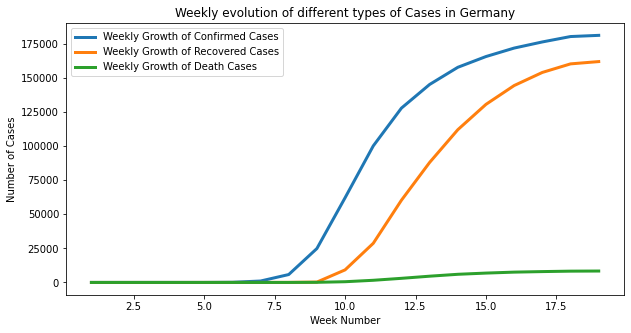

In [ ]:
#Weekly evolution of different Types of Cases in Germany
Germany_grouped["WeekOfYear"]=Germany_grouped.index.weekofyear

week_num_Germany=[]
Germany_weekly_confirmed=[]
Germany_weekly_recovered=[]
Germany_weekly_deaths=[]
w=1
for i in list(Germany_grouped["WeekOfYear"].unique()):
    Germany_weekly_confirmed.append(Germany_grouped[Germany_grouped["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    Germany_weekly_recovered.append(Germany_grouped[Germany_grouped["WeekOfYear"]==i]["Recovered"].iloc[-1])
    Germany_weekly_deaths.append(Germany_grouped[Germany_grouped["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num_Germany.append(w)
    w=w+1
    
plt.figure(figsize=(10,5))
plt.plot(week_num_Germany,Germany_weekly_confirmed,linewidth=3,label="Weekly Growth of Confirmed Cases")
plt.plot(week_num_Germany,Germany_weekly_recovered,linewidth=3,label="Weekly Growth of Recovered Cases")
plt.plot(week_num_Germany,Germany_weekly_deaths,linewidth=3,label="Weekly Growth of Death Cases")
plt.xlabel('Week Number')
plt.ylabel("Number of Cases")
plt.title("Weekly evolution of different types of Cases in Germany")
plt.legend()

It took 80 days in Italy to reach number of Confirmed Cases equivalent to Germany
It took 69 days in USA to reach number of Confirmed Cases equivalent to Germany
It took 75 days in Spain to reach number of Confirmed Cases equivalent to Germany
It took 121 days in Germany to reach 181200 Confirmed Cases


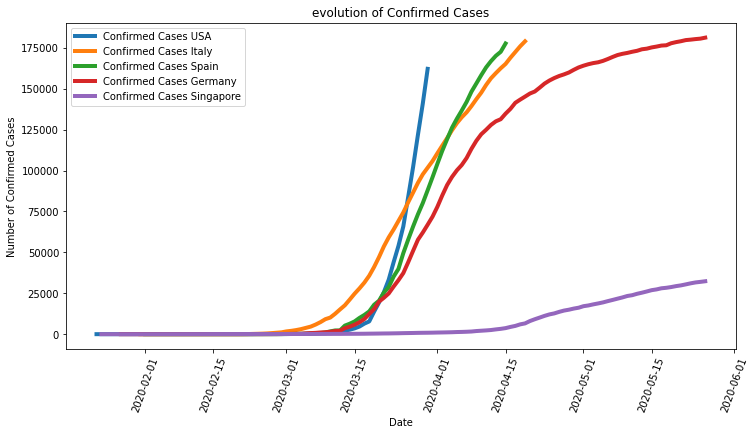

In [ ]:
#Comparison of evolution of confirmed Cases in Germany and [Italy, Spain, USA, Singapore] over time

max_ind=Germany_grouped["Confirmed"].max()

Italy_covid=full_data[full_data["Country/Region"]=="Italy"]
Italy_data=Italy_covid.groupby(["date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

Spain_covid=full_data[full_data["Country/Region"]=="Spain"]
Spain_data=Spain_covid.groupby(["date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

US_covid=full_data[full_data["Country/Region"]=="United States"]
US_data=US_covid.groupby(["date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})


Singapore_covid=full_data[full_data["Country/Region"]=="Singapore"]
Singapore_data=Singapore_covid.groupby(["date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

plt.figure(figsize=(12,6))
plt.plot(US_data[(US_data["Confirmed"]>0)&(US_data["Confirmed"]<=max_ind)]["Confirmed"],label="Confirmed Cases USA",linewidth=4)
plt.plot(Italy_data[(Italy_data["Confirmed"]>0)&(Italy_data["Confirmed"]<=max_ind)]["Confirmed"],label="Confirmed Cases Italy",linewidth=4)
plt.plot(Spain_data[(Spain_data["Confirmed"]>0)&(Spain_data["Confirmed"]<=max_ind)]["Confirmed"],label="Confirmed Cases Spain",linewidth=4)
plt.plot(Germany_grouped[Germany_grouped["Confirmed"]>0]["Confirmed"],label="Confirmed Cases Germany",linewidth=4)
plt.plot(Singapore_data[(Singapore_data["Confirmed"]>0)&(Singapore_data["Confirmed"]<=max_ind)]["Confirmed"],label="Confirmed Cases Singapore",linewidth=4)

plt.xlabel("Date")
plt.ylabel("Number of Confirmed Cases")
plt.title("evolution of Confirmed Cases")
plt.legend()
plt.xticks(rotation=70)

print("It took",Italy_data[(Italy_data["Confirmed"]>0)&(Italy_data["Confirmed"]<=max_ind)].shape[0],"days in Italy to reach number of Confirmed Cases equivalent to Germany")
print("It took",US_data[(US_data["Confirmed"]>0)&(US_data["Confirmed"]<=max_ind)].shape[0],"days in USA to reach number of Confirmed Cases equivalent to Germany")
print("It took",Spain_data[(Spain_data["Confirmed"]>0)&(Spain_data["Confirmed"]<=max_ind)].shape[0],"days in Spain to reach number of Confirmed Cases equivalent to Germany")
print("It took",Germany_grouped[Germany_grouped["Confirmed"]>0].shape[0],"days in Germany to reach",max_ind,"Confirmed Cases")


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.,
        737560., 737577.]), <a list of 9 Text major ticklabel objects>)

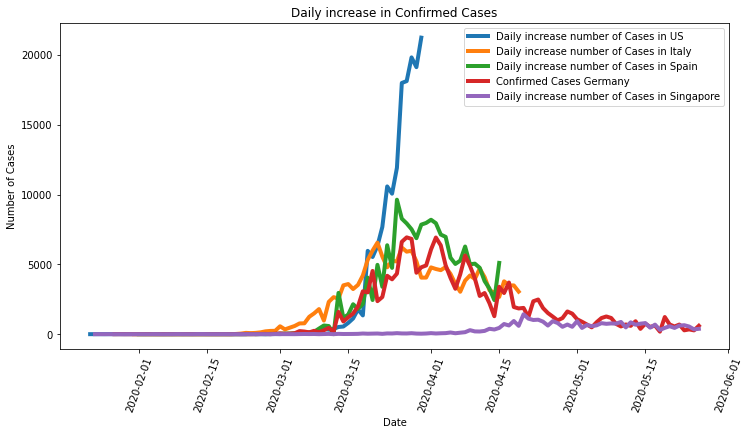

In [ ]:
#Comparison of Daily increase of Nb confirmed Cases in Germany and [Italy, Spain, USA, Singapore]
plt.figure(figsize=(12,6))
plt.plot(US_data[(US_data["Confirmed"]>0)&(US_data["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),label="Daily increase number of Cases in US",linewidth=4)
plt.plot(Italy_data[(Italy_data["Confirmed"]>0)&(Italy_data["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),label="Daily increase number of Cases in Italy",linewidth=4)
plt.plot(Spain_data[(Spain_data["Confirmed"]>0)&(Spain_data["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),label="Daily increase number of Cases in Spain",linewidth=4)
plt.plot(Germany_grouped[Germany_grouped["Confirmed"]>0]["Confirmed"].diff().fillna(0),label="Confirmed Cases Germany",linewidth=4)
plt.plot(Singapore_data[(Singapore_data["Confirmed"]>0)&(Singapore_data["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),label="Daily increase number of Cases in Singapore",linewidth=4)

plt.ylabel("Number of Cases")
plt.xlabel("Date")
plt.title("Daily increase in Confirmed Cases")
plt.legend()
plt.xticks(rotation=70)

(array([737470., 737485., 737499., 737516., 737530., 737546., 737560.]),
 <a list of 7 Text major ticklabel objects>)

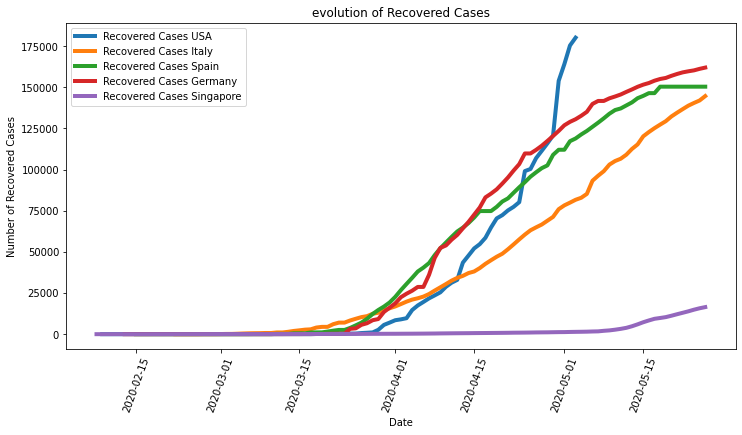

In [ ]:
#Comparison of evolution of Nb Recovered Cases in Germany and [Italy, Spain, USA, Singapore]

plt.figure(figsize=(12,6))
plt.plot(US_data[(US_data["Recovered"]>0)&(US_data["Recovered"]<=max_ind)]["Recovered"],label="Recovered Cases USA",linewidth=4)
plt.plot(Italy_data[(Italy_data["Recovered"]>0)&(Italy_data["Recovered"]<=max_ind)]["Recovered"],label="Recovered Cases Italy",linewidth=4)
plt.plot(Spain_data[(Spain_data["Recovered"]>0)&(Spain_data["Recovered"]<=max_ind)]["Recovered"],label="Recovered Cases Spain",linewidth=4)
plt.plot(Germany_grouped[Germany_grouped["Recovered"]>0]["Recovered"],label="Recovered Cases Germany",linewidth=4)
plt.plot(Singapore_data[(Singapore_data["Recovered"]>0)&(Singapore_data["Recovered"]<=max_ind)]["Recovered"],label="Recovered Cases Singapore",linewidth=4)

plt.xlabel("Date")
plt.ylabel("Number of Recovered Cases")
plt.title("evolution of Recovered Cases")
plt.legend()
plt.xticks(rotation=70)


(array([737485., 737499., 737516., 737530., 737546., 737560.]),
 <a list of 6 Text major ticklabel objects>)

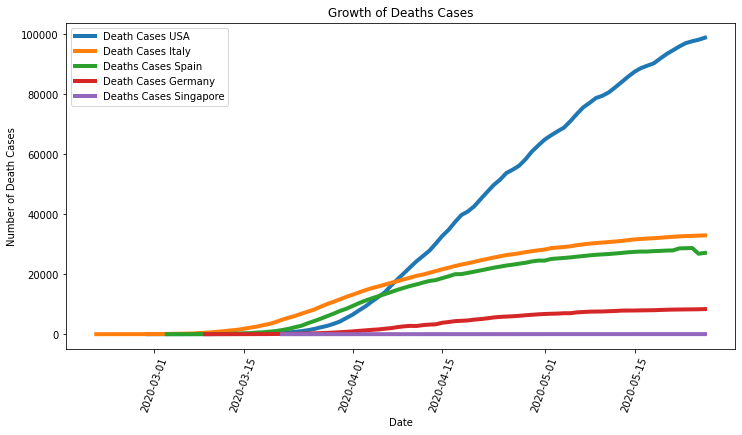

In [ ]:
#Comparison of Growth in Nb of deaths in Germany and [Italy, Spain, USA, Singapore]

plt.figure(figsize=(12,6))
plt.plot(US_data[(US_data["Deaths"]>0)&(US_data["Deaths"]<=max_ind)]["Deaths"],label="Death Cases USA",linewidth=4)
plt.plot(Italy_data[(Italy_data["Deaths"]>0)&(Italy_data["Deaths"]<=max_ind)]["Deaths"],label="Death Cases Italy",linewidth=4)
plt.plot(Spain_data[(Spain_data["Deaths"]>0)&(Spain_data["Deaths"]<=max_ind)]["Deaths"],label="Deaths Cases Spain",linewidth=4)
plt.plot(Germany_grouped[Germany_grouped["Deaths"]>0]["Deaths"],label="Death Cases Germany",linewidth=4)
plt.plot(Singapore_data[(Singapore_data["Deaths"]>0)&(Singapore_data["Deaths"]<=max_ind)]["Deaths"],label="Deaths Cases Singapore",linewidth=4)

plt.xlabel("Date")
plt.ylabel("Number of Death Cases")
plt.title("Growth of Deaths Cases")
plt.legend()
plt.xticks(rotation=70)


Saving demographics_de.csv to demographics_de.csv
Saving covid_de.csv to covid_de.csv


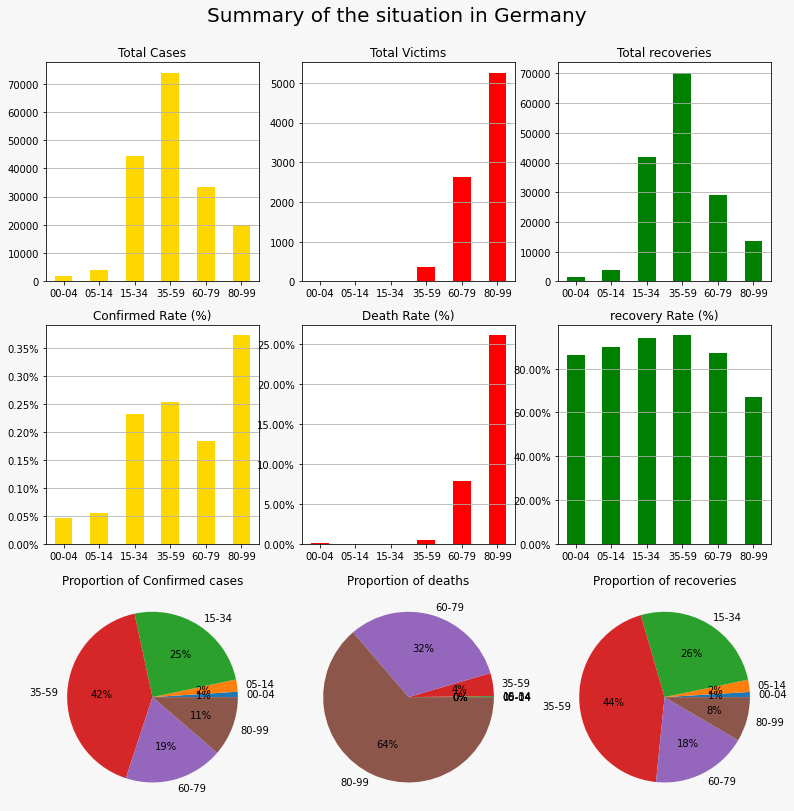

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
covid_de = pd.read_csv(io.BytesIO(uploaded['covid_de.csv']))
german_pop = pd.read_csv(io.BytesIO(uploaded['demographics_de.csv']))
covid_de['date'] = pd.to_datetime(covid_de['date']).dt.date
covid_de = covid_de.groupby(['state', 'age_group', 'gender', 'date'], as_index=False).sum()

germany_data = pd.merge(covid_de, german_pop, on=['state', 'age_group', 'gender'], how='left').sort_values('date')

germany_data.rename(columns={'cases': 'Confirmed', 'deaths': 'deaths'}, inplace=True)

age_wise = germany_data.groupby('age_group', as_index=False)[['deaths', 'recovered','Confirmed']].sum()
german_pop = german_pop.groupby('age_group').population.sum()
age_wise = pd.merge(age_wise, german_pop, on='age_group')
age_wise['confirmed_rate'] = age_wise['Confirmed'] / age_wise['population']
age_wise['death_rate'] = age_wise['deaths'] / age_wise['Confirmed']
age_wise['recovery_rate'] = age_wise['recovered'] / age_wise['Confirmed']

age_wise['prop_confirmed'] = age_wise['Confirmed'] / age_wise['Confirmed'].sum()
age_wise['prop_deaths'] = age_wise['deaths'] / age_wise['deaths'].sum()
age_wise['prop_recovery'] = age_wise['recovered'] / age_wise['recovered'].sum()


fig, ax = plt.subplots(3,3, figsize=(13, 13), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.92)
fig.suptitle('Summary of the situation in Germany', fontsize=20)

age_wise.set_index('age_group').Confirmed.plot(kind='bar', ax=ax[0][0], color='gold')
age_wise.set_index('age_group').deaths.plot(kind='bar', ax=ax[0][1], color='red')
age_wise.set_index('age_group').recovered.plot(kind='bar', ax=ax[0][2], color='green')

age_wise.set_index('age_group').confirmed_rate.plot(kind='bar', ax=ax[1][0], color='gold')
age_wise.set_index('age_group').death_rate.plot(kind='bar', ax=ax[1][1], color='red')
age_wise.set_index('age_group').recovery_rate.plot(kind='bar', ax=ax[1][2], color='green')

ax[2][0].pie(age_wise.prop_confirmed.values, labels=age_wise.age_group, autopct='%.0f%%')
ax[2][1].pie(age_wise.prop_deaths.values, labels=age_wise.age_group, autopct='%.0f%%')
ax[2][2].pie(age_wise.prop_recovery.values, labels=age_wise.age_group, autopct='%.0f%%')

ax[0][0].set_title('Total Cases', fontsize=12)
ax[0][1].set_title('Total Victims', fontsize=12)
ax[0][2].set_title('Total recoveries', fontsize=12)

ax[1][0].set_title('Confirmed Rate (%)', fontsize=12)
ax[1][1].set_title('Death Rate (%)', fontsize=12)
ax[1][2].set_title('recovery Rate (%)', fontsize=12)

ax[2][0].set_title('Proportion of Confirmed cases', fontsize=12)
ax[2][1].set_title('Proportion of deaths', fontsize=12)
ax[2][2].set_title('Proportion of recoveries', fontsize=12)


for axes in ax[0]:
    axes.set_xlabel('')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0)
    axes.grid(axis='y')
for axes in ax[1]:
    axes.set_xlabel('')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0)
    axes.grid(axis='y')
    axes.set_yticklabels(['{:,.2%}'.format(x) for x in axes.get_yticks()])

plt.show()

['Bayern' 'Nordrhein-Westfalen' 'Niedersachsen' 'Baden-Wuerttemberg'
 'Schleswig-Holstein' 'Hamburg' 'Hessen' 'Rheinland-Pfalz' 'Brandenburg'
 'Bremen' 'Sachsen' 'Berlin' 'Mecklenburg-Vorpommern' 'Thueringen'
 'Saarland' 'Sachsen-Anhalt']


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.,
        737560.]), <a list of 8 Text major ticklabel objects>)

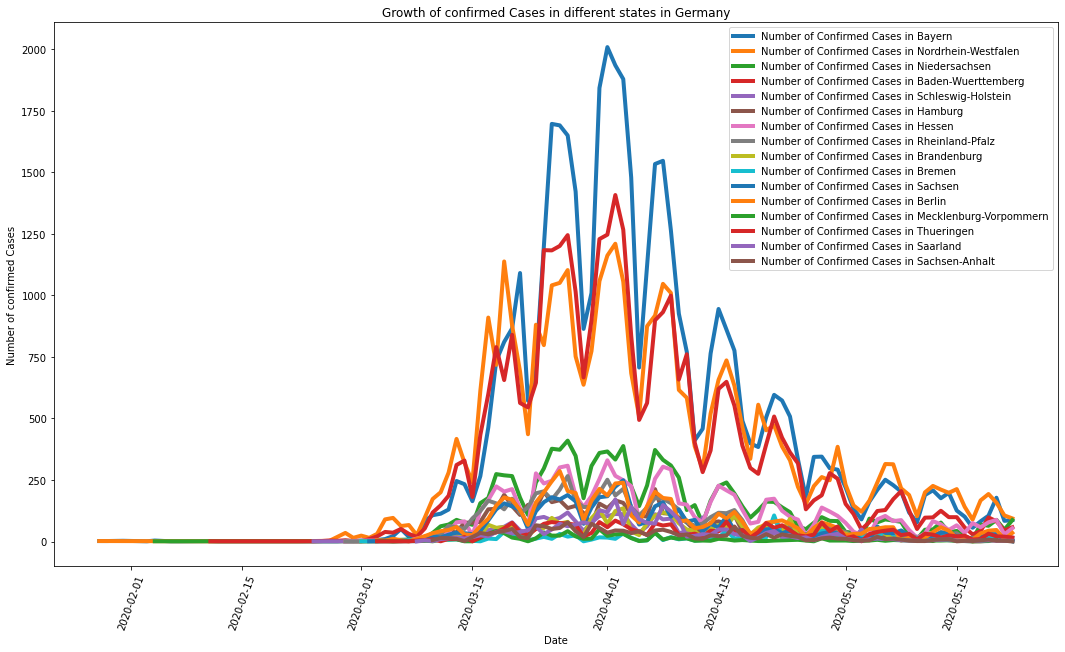

In [ ]:
%matplotlib inline

tmp_germany = covid_de.groupby(['date', 'state'], as_index=False).sum().set_index('date')

print(tmp_germany['state'].unique())

plt.figure(figsize=(18,10))
for c in tmp_germany['state'].unique():
    plt.plot(tmp_germany[tmp_germany['state'] == c]['cases'],label="Number of Confirmed Cases in " + c,linewidth=4)

plt.xlabel("Date")
plt.ylabel("Number of confirmed Cases")
plt.title("Growth of confirmed Cases in different states in Germany")
plt.legend()
plt.xticks(rotation=70)



Text(0.5, 1.0, 'Top 3 German states in terms of recovered Cases')

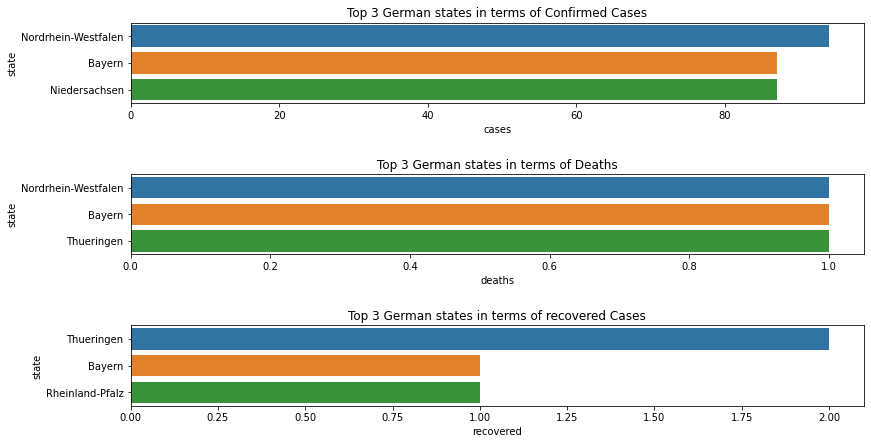

In [ ]:
by_state=covid_de[covid_de["date"]==covid_de["date"].max()].groupby(["state"]).agg({"cases":'sum',"recovered":'sum',"deaths":'sum'}).sort_values(["cases"],ascending=False)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(12,7))
#Sort countries with respect to different types of cases recently detected
top_3_conf_states=by_state.sort_values(["cases"],ascending=False).head(3)
top_3_death_states=by_state.sort_values(["deaths"],ascending=False).head(3)
top_3_recovered_states=by_state.sort_values(["recovered"],ascending=False).head(3)

fig.tight_layout(pad=5.0)

#Plot Barplot comparing top 10 countries
sns.barplot(x=top_3_conf_states["cases"],y=top_3_conf_states.index,ax=ax1)
ax1.set_title("Top 3 German states in terms of Confirmed Cases")

sns.barplot(x=top_3_death_states["deaths"],y=top_3_death_states.index,ax=ax2)
ax2.set_title("Top 3 German states in terms of Deaths")

sns.barplot(x=top_3_recovered_states["recovered"],y=top_3_recovered_states.index,ax=ax3)
ax3.set_title("Top 3 German states in terms of recovered Cases")

# Feature engineering:

### 1- Add population and distribution of age gaps for each country

In [ ]:
dftemp = full_data

#Import the world population dataset
"""uploaded = files.upload()

import io"""
wpop = pd.read_csv('WPP2019_PopulationByAgeSex_Medium.csv')

#choose only the values of 2020
wpop20 = wpop[wpop['Time']==2020].reset_index(drop=True)

#Fix countries names to match those in Covid19 dataset
nw_country = {
'Iran (Islamic Republic of)' : "Iran",
'Bolivia (Plurinational State of)' : 'Bolivia',
'Brunei Darussalam' : 'Brunei',
'Congo' : 'Congo (Kinshasa)',
'Democratic Republic of the Congo' : "Congo (Brazzaville)",
"Côte d'Ivoire": "Cote d'Ivoire",
"Gambia" : "Gambia, The",
"Republic of Korea": "Korea, South",
"Republic of Moldova": "Moldova",
'Réunion' : "Reunion",
'Russian Federation' : "Russia",
'China, Taiwan Province of China' : "Taiwan*",
"United Republic of Tanzania": "Tanzania",
"Bahamas": "The Bahamas",
"Gambia": "The Gambia",
"United States of America (and dependencies)" : "US",
"Venezuela (Bolivarian Republic of)" : "Venezuela",
'Viet Nam' : "Vietnam"}

def rename_countries(k, country_dict):
    new_name = country_dict.get(k)
    if new_name is not None:
        return new_name
    else:
        return k

wpop20['Location'] = wpop20.Location.apply(lambda k : rename_countries(k, nw_country))
clean_wpop = wpop20[wpop20['Location'].isin(dftemp['Country/Region'].unique())].reset_index()

population_distribution = []
for country, gpdf in clean_wpop.groupby("Location"):
    aux = {f"age_{age_grp}": tot for age_grp, tot in zip(gpdf.AgeGrp, gpdf.PopTotal)}
    aux["Country/Region"] = country
    population_distribution.append(aux)
    
df_pop_distrib = pd.DataFrame(population_distribution)

# add missing countries with median values
no_data = []
for country in dftemp['Country/Region'].unique():
    if country not in df_pop_distrib['Country/Region'].unique():
        aux = df_pop_distrib.drop('Country/Region', axis=1).median(axis=0).to_dict()
        aux["Country/Region"] = country
        no_data.append(aux)
df_no_data = pd.DataFrame(no_data)

df_pop_distrib = pd.concat([df_pop_distrib, df_no_data], axis=0)

# normalize features
norm_pop_distrib = df_pop_distrib.drop("Country/Region", axis=1).div(df_pop_distrib.drop("Country/Region", axis=1).sum(axis=1), axis=0)
norm_pop_distrib['total_pop'] = df_pop_distrib.drop("Country/Region", axis=1).sum(axis=1)
norm_pop_distrib["Country/Region"] = df_pop_distrib["Country/Region"]

#delete auxiliary dataframes
del df_pop_distrib
del df_no_data
del clean_wpop
del wpop20

#merge the covid19 and world population datasets
dftemp = dftemp.merge(norm_pop_distrib, on="Country/Region", how='left')

#Combine age gaps to larger intervals
dftemp['age_under-20'] = dftemp['age_0-4'] + dftemp['age_5-9'] + dftemp['age_10-14'] + dftemp['age_15-19']
dftemp['age_20-40'] = dftemp['age_20-24'] + dftemp['age_25-29'] + dftemp['age_30-34'] + dftemp['age_35-39']
dftemp['age_40-60'] = dftemp['age_40-44'] + dftemp['age_45-49'] + dftemp['age_50-54'] + dftemp['age_55-59']
dftemp['age_over-60'] = dftemp['age_60-64'] + dftemp['age_65-69'] + dftemp['age_70-74'] + dftemp['age_75-79'] + dftemp['age_80-84'] + dftemp['age_85-89'] + dftemp['age_90-94'] + dftemp['age_95-99'] + dftemp['age_100+']

#drop old age columns:
dftemp = dftemp.drop(['age_0-4','age_5-9', 'age_10-14', 'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39','age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64', 'age_65-69','age_70-74','age_75-79', 'age_80-84','age_85-89', 'age_90-94', 'age_95-99', 'age_100+' ] , 1)


In [ ]:
dftemp.head()

,Country/Region,Confirmed,date,Deaths,Recovered,total_pop,age_under-20,age_20-40,age_40-60,age_over-60
0,Afghanistan,0,2020-01-22,0,0,38928.341,0.537148,0.297226,0.123397,0.042228
1,Albania,0,2020-01-22,0,0,2877.800,0.241716,0.300039,0.246407,0.211838
2,Algeria,0,2020-01-22,0,0,43851.043,0.374204,0.315818,0.210911,0.099067
3,Andorra,0,2020-01-22,0,0,7975.748,0.344365,0.318983,0.226930,0.109722
4,Angola,0,2020-01-22,0,0,32866.268,0.571435,0.274012,0.117973,0.036579


### 2- Add smoking percentage of each country

In [ ]:
#smokers = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/shareofadultswhosmoke/adults-smoking-2000-2016.csv')

#Import the share of adults who smoke dataset
uploaded = files.upload()

import io
smokers = pd.read_csv(io.BytesIO(uploaded['adults-smoking-2000-2016.csv']))


#We choose the data from 2016 since it's the closest to be up-to-date
smokers = smokers[smokers.Year == 2016].reset_index(drop=True)

#Fix countries names to match those in Covid19 dataset
smokers_country_dict = {'North America' : "US",
 'Gambia' : "The Gambia",
 'Bahamas': "The Bahamas",
 "'South Korea'" : "Korea, South",
'Papua New Guinea' : "Guinea",
 "'Czech Republic'" : "Czechia",
 'Congo' : "Congo (Brazzaville)"}

smokers['Entity'] = smokers.Entity.apply(lambda x : rename_countries(x, smokers_country_dict))

#rename the column containing coutries names to match the covid-19 dataset
smokers = smokers.rename(columns={'Entity': 'Country/Region'})

#remove unecessary columns
smokers = smokers.drop(['Code','Year', 'Share of adults who smoke in 2000 (%)'] , 1)

#merge the covid19 and smokers dataset
dftempaux = dftemp.merge(smokers, on="Country/Region", how='left')

#fill the missing values in some countries with the mean 
mean_smoke = smokers['Share of adults who smoke (%)'].mean()
dftempaux['Share of adults who smoke (%)'] = dftempaux['Share of adults who smoke (%)'].fillna(mean_smoke)
dftempaux.head()


Saving adults-smoking-2000-2016.csv to adults-smoking-2000-2016.csv


,Country/Region,Confirmed,date,Deaths,Recovered,total_pop,age_under-20,age_20-40,age_40-60,age_over-60,Share of adults who smoke (%)
0,Afghanistan,0,2020-01-22,0,0,38928.341,0.537148,0.297226,0.123397,0.042228,21.389448
1,Albania,0,2020-01-22,0,0,2877.800,0.241716,0.300039,0.246407,0.211838,28.700000
2,Algeria,0,2020-01-22,0,0,43851.043,0.374204,0.315818,0.210911,0.099067,15.600000
3,Andorra,0,2020-01-22,0,0,7975.748,0.344365,0.318983,0.226930,0.109722,33.500000
4,Angola,0,2020-01-22,0,0,32866.268,0.571435,0.274012,0.117973,0.036579,21.389448


### 3- Adding more features

In [ ]:

#country_info = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/countryinfo/covid19countryinfo.csv')

#Import the covid19 country info dataset
uploaded = files.upload()

import io
country_info = pd.read_csv(io.BytesIO(uploaded['covid19countryinfo.csv']))


#select only the columns we want to add
country_info = country_info[['country', 'density', 'urbanpop', 'quarantine', 'schools',  'hospibed', 'gathering' ]]

#rename the column containing coutries names to match the covid-19 dataset
country_info = country_info.rename(columns={'country': 'Country/Region'})

country_info = country_info[country_info['Country/Region'].duplicated()==False]
country_info[country_info['Country/Region'].duplicated()]

#merge the 2 datasets
dftempaux = dftempaux.merge(country_info, on= 'Country/Region', how='left')
print(dftempaux.shape)
dftempaux.head()


Saving covid19countryinfo.csv to covid19countryinfo.csv
(23688, 17)


,Country/Region,Confirmed,date,Deaths,Recovered,total_pop,age_under-20,age_20-40,age_40-60,age_over-60,Share of adults who smoke (%),density,urbanpop,quarantine,schools,hospibed,gathering
0,Afghanistan,0,2020-01-22,0,0,38928.341,0.537148,0.297226,0.123397,0.042228,21.389448,60.0,25.0,NaN,NaN,0.5,NaN
1,Albania,0,2020-01-22,0,0,2877.800,0.241716,0.300039,0.246407,0.211838,28.700000,105.0,63.0,NaN,NaN,2.9,NaN
2,Algeria,0,2020-01-22,0,0,43851.043,0.374204,0.315818,0.210911,0.099067,15.600000,18.0,73.0,NaN,NaN,1.9,NaN
3,Andorra,0,2020-01-22,0,0,7975.748,0.344365,0.318983,0.226930,0.109722,33.500000,164.0,88.0,NaN,NaN,2.5,NaN
4,Angola,0,2020-01-22,0,0,32866.268,0.571435,0.274012,0.117973,0.036579,21.389448,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("null values:\n",dftempaux.isnull().sum())

null values:
 Country/Region                       0
Confirmed                            0
date                                 0
Deaths                               0
Recovered                            0
total_pop                            0
age_under-20                         0
age_20-40                            0
age_40-60                            0
age_over-60                          0
Share of adults who smoke (%)        0
density                           2268
urbanpop                          2268
quarantine                       20664
schools                          20790
hospibed                          2268
gathering                        22302
dtype: int64


In [ ]:
#density, pop, urbanpop, quarantine, schools, restrictions, hospibed

#need to replace that with a joint using Pandas
dftempaux['urbanpop'].fillna(dftempaux['urbanpop'].mode()[0])
dftempaux['hospibed'].fillna(dftempaux['hospibed'].mode()[0])
dftempaux['density'].fillna(dftempaux['density'].mode()[0])

dftempaux.head()

### 4- Feature Engineering of Covid19 data : Lag Features

In [ ]:
enriched = dftempaux

def calc_lag(data, lag, column):
    for l in lag:
        col_lag = column + "_" + str(l)
        data[col_lag] = data.groupby(['Country/Region'])[column].shift(l, fill_value=0)
    return data

enriched = calc_lag(enriched.reset_index(), range(1,7), 'Confirmed')
enriched = calc_lag(enriched, range(1,7), 'Deaths')
enriched = calc_lag(enriched, range(1,7), 'Recovered')

#enriched.fillna(0, inplace=True)

enriched.head()

,index,Country/Region,Confirmed,date,Deaths,Recovered,total_pop,age_under-20,age_20-40,age_40-60,age_over-60,Share of adults who smoke (%),density,urbanpop,quarantine,schools,hospibed,gathering,Confirmed_1,Confirmed_2,Confirmed_3,Confirmed_4,Confirmed_5,Confirmed_6,Deaths_1,Deaths_2,Deaths_3,Deaths_4,Deaths_5,Deaths_6,Recovered_1,Recovered_2,Recovered_3,Recovered_4,Recovered_5,Recovered_6
0,0,Afghanistan,0,2020-01-22,0,0,38928.341,0.537148,0.297226,0.123397,0.042228,21.389448,60.0,25.0,NaN,NaN,0.5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Albania,0,2020-01-22,0,0,2877.800,0.241716,0.300039,0.246407,0.211838,28.700000,105.0,63.0,NaN,NaN,2.9,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Algeria,0,2020-01-22,0,0,43851.043,0.374204,0.315818,0.210911,0.099067,15.600000,18.0,73.0,NaN,NaN,1.9,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,Andorra,0,2020-01-22,0,0,7975.748,0.344365,0.318983,0.226930,0.109722,33.500000,164.0,88.0,NaN,NaN,2.5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Angola,0,2020-01-22,0,0,32866.268,0.571435,0.274012,0.117973,0.036579,21.389448,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 5- Feature Engineering  of Covid19 data : Rolling Window Feature

In [ ]:
enriched['Conf_rolling_mean'] = enriched['Confirmed'].rolling(window=7).mean()
enriched['recov_rolling_mean'] = enriched['Recovered'].rolling(window=7).mean()
enriched['deaths_rolling_mean'] = enriched['Deaths'].rolling(window=7).mean()
enriched.head()

,index,Country/Region,Confirmed,date,Deaths,Recovered,total_pop,age_under-20,age_20-40,age_40-60,age_over-60,Share of adults who smoke (%),density,urbanpop,quarantine,schools,hospibed,gathering,Confirmed_1,Confirmed_2,Confirmed_3,Confirmed_4,Confirmed_5,Confirmed_6,Deaths_1,Deaths_2,Deaths_3,Deaths_4,Deaths_5,Deaths_6,Recovered_1,Recovered_2,Recovered_3,Recovered_4,Recovered_5,Recovered_6,Conf_rolling_mean,recov_rolling_mean,deaths_rolling_mean
0,0,Afghanistan,0,2020-01-22,0,0,38928.341,0.537148,0.297226,0.123397,0.042228,21.389448,60.0,25.0,NaN,NaN,0.5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,Albania,0,2020-01-22,0,0,2877.800,0.241716,0.300039,0.246407,0.211838,28.700000,105.0,63.0,NaN,NaN,2.9,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2,Algeria,0,2020-01-22,0,0,43851.043,0.374204,0.315818,0.210911,0.099067,15.600000,18.0,73.0,NaN,NaN,1.9,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,3,Andorra,0,2020-01-22,0,0,7975.748,0.344365,0.318983,0.226930,0.109722,33.500000,164.0,88.0,NaN,NaN,2.5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,4,Angola,0,2020-01-22,0,0,32866.268,0.571435,0.274012,0.117973,0.036579,21.389448,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


### 6- Feature relevance Heat map:

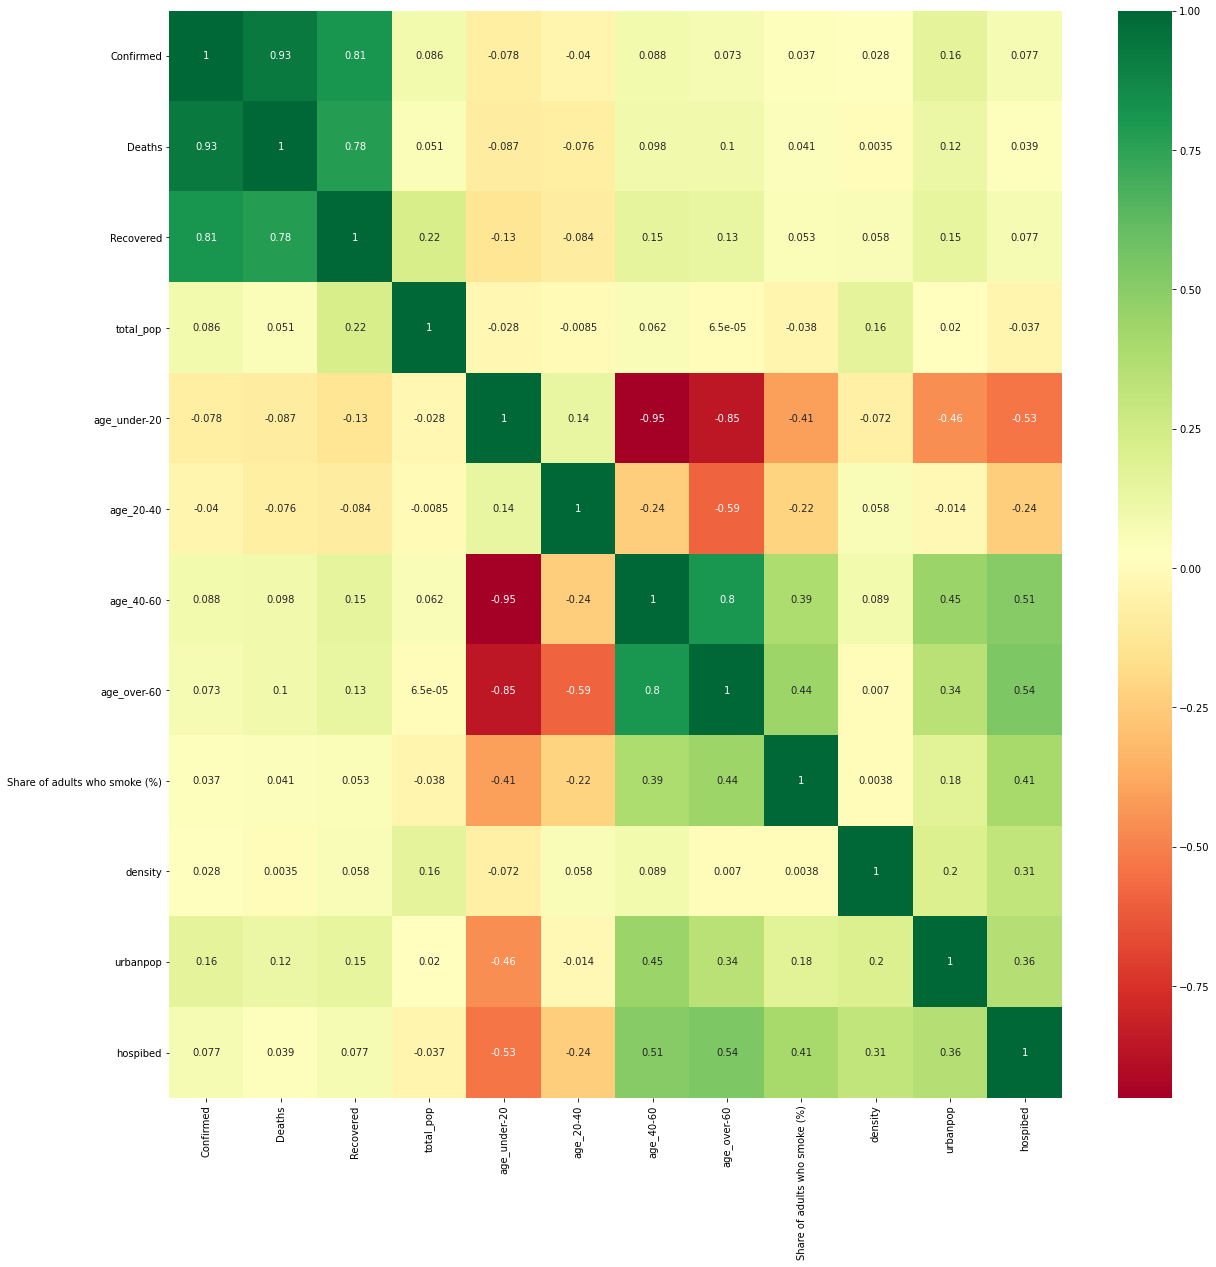

In [ ]:

dataX = dftempaux  
y = dataX['Confirmed']

nw_columns = ["Confirmed", "Country/Region", "date", "quarantine", "gathering","schools", "hospibed","density"]
select = [x for x in dataX.columns if x not in nw_columns]
X = dataX.loc[:, select]


#get correlations of each features in dataset
corrmat = dataX.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dataX[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 7- Stationarity:

In [ ]:
conf_cases.to_csv('conf_cases.csv')

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

In [ ]:
# invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

In [ ]:
# difference the dataset
diff = difference(conf_cases['Confirmed'])
print(diff)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 548, -548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -2, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 2, -2, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 643, -643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -2, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# invert the difference
inverted = [inverse_difference(conf_cases['Confirmed'][i], diff[i]) for i in range(len(diff))]
print(inverted)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,